Vanguard Sector ETFs
- [Vanguard Sector ETFs](https://investor.vanguard.com/investment-products/list/etfs?assetclass=sector_specialty&filters=open)

- VOX Communication Services
- VCR Consumer Discretionary
- VDC Consumer Staples
- VDE Energy
- VFH Financials
- VHT Health Care
- VIS Industrials
- VGT Information Technology
- VAW Materials
- VNQ Real Estate
- VPU Utilities

Yahoo Finance Python Project
- [Yahoo Finance Python Project](https://pypi.org/project/yfinance/)
- 1y, 1mo, etc.

- [Seaborn](https://seaborn.pydata.org/index.html)

In [15]:
# import modules
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pingouin as pg

from stateprocessor import StateProcessor

In [1]:
# globals
TIME_PERIOD = "5y" # yahoo finance format
LOR = 3
DATASETS = [
    'VOX Communication Services',
    'VCR Consumer Discretionary',
    'VDC Consumer Staples',
    'VDE Energy',
    'VFH Finacials',
    'VHT Health Car',
    'VIS Industrials',
    'VGT Information Technology',
    'VAW Materials',
    'VNQ Real Estate',
    'VPU Utilities'
] # 11 sector etfs

In [ ]:
# functions

# compare_col = name of column that is compared to get the up and down states
def calculate_state(df, compare_col, lor):
    df['upstate'] = 0
    df['downstate'] = 0
    df['totalstate'] = 0 # total state is upstate and downstate combined where downstate values are negative (zeroes will exist at state switch)
    df['flowstate'] = 0 # running tally where upstate gives plus 1 and downstate gives minus 1
    df['volumestate'] = 0
    # returns based on previous day
    df['trail_returns'] = 0
    df['trail_returns_per'] = 0
    # returns based on next day
    df['lead_returns'] = 0
    df['lead_returns_per'] = 0
    df['lor_returns'] = 0
    df['lor_returns_per'] = 0
    prev_row = df.iloc[0]
    for index, curr_row in df.iterrows():
        if index > 0:
            # volumestate flow
            # volume is increasing
            if prev_row['Volume'] < curr_row['Volume']:
                # if volume switches (from down to up), restart volumestate at 0
                if prev_row["volumestate"] < 0:
                    df.at[index, 'volumestate'] = 0
                # increment streak of daily increasing volume
                else:
                    df.at[index, 'volumestate'] = prev_row['volumestate'] + 1
            # volume is decreasing
            else:
                # if volume switches (from up to down), restart volumestate at 0
                if prev_row["volumestate"] > 0:
                    df.at[index, 'volumestate'] = 0
                # increment streak of daily decreasing volume
                else:
                    df.at[index, 'volumestate'] = prev_row['volumestate'] - 1
            
            # upstate flow
            if prev_row[compare_col] < curr_row[compare_col]:
                df.at[index, 'upstate'] = prev_row['upstate'] + 1
                df.at[index, 'flowstate'] = prev_row['flowstate'] + 1
                # if state switches (fron down to up), restart count
                if prev_row["downstate"] != 0:
                    df.at[index, 'totalstate'] = 0
                else:
                    df.at[index, 'totalstate'] = prev_row['totalstate'] + 1
            # downstate flow
            else:
                df.at[index, 'downstate'] = prev_row['downstate'] + 1
                df.at[index, 'flowstate'] = prev_row['flowstate'] - 1
                # if state switches (from up to down), restart count
                if prev_row["upstate"] != 0:
                    df.at[index, 'totalstate'] = 0
                else:
                    df.at[index, 'totalstate'] = prev_row['totalstate'] - 1
            # calculate trailing returns based on previous day
            df.at[index, 'trail_returns'] = curr_row['Close'] - prev_row['Close']
            df.at[index, 'trail_returns_per'] = (curr_row['Close'] - prev_row['Close']) / prev_row['Close'] * 100

            if (index < len(df)-1):
                # calculate leading returns based on next day
                next_row = df.iloc[index+1]
                df.at[index, 'lead_returns'] = next_row['Close'] - curr_row['Close']
                df.at[index, 'lead_returns_per'] = (next_row['Close'] - curr_row['Close']) / curr_row['Close'] * 100
            
            # calculate returns based on length of return parameter
            # ex: lor = 5
            if (index < len(df)-lor):
                lor_row = df.iloc[index + lor] #5th day
                # 5th day close - curr close = return over 5 days? Yes
                # can we use df.pct_chg()?
                df.at[index, 'lor_returns'] = (lor_row['Close'] - curr_row['Close'])
                df.at[index, 'lor_returns_per'] = (lor_row['Close'] - curr_row['Close']) / curr_row['Close'] * 100
            
            prev_row = df.iloc[index] # use df and index bc 'curr_row' is a copy
    return df


def plot_histogram(df, data_col_name, title, xlabel, xlim, xmax, ylabel, ylim, ymax):
    # Plot Histogram
    # https://seaborn.pydata.org/tutorial/distributions.html
    upper_threshold = np.quantile(df[data_col_name].iloc[1:], .95)
    lower_threshold = np.quantile(df[data_col_name].iloc[1:], .05)

    sns.displot(df[data_col_name], kde=True, discrete=True)
    plt.axvline(x=upper_threshold, linewidth=1, color='green', ls='--')
    plt.axvline(x=lower_threshold, linewidth=1, color='red', ls='--')
    plt.title(title)
    plt.xlim(xlim, xmax)
    plt.xlabel(xlabel)
    plt.ylim(ylim, ymax)
    plt.ylabel(ylabel)
    plt.show()

    # counts, edges, bars = plt.hist(df[data_col_name], bins=len(set(df[data_col_name])))
    # plt.bar_label(bars)

    # plt.title(title)
    # plt.xlim(xlim, xmax)
    # plt.xlabel(xlabel)
    # plt.ylim(ylim, ymax)
    # plt.ylabel(ylabel)
    # plt.show()

In [5]:
# load the 11 vanguard sector etfs
vox = yf.Ticker("VOX")
vcr = yf.Ticker("VCR")
vdc = yf.Ticker("VDC")
vde = yf.Ticker("VDE")
vfh = yf.Ticker("VFH")
vht = yf.Ticker("VHT")
vis = yf.Ticker("VIS")
vgt = yf.Ticker("VGT")
vaw = yf.Ticker("VAW")
vnq = yf.Ticker("VNQ")
vpu = yf.Ticker("VPU")

sector_etf_tps = [] # list of dataframes

vox_tp = vox.history(period=TIME_PERIOD)
sector_etf_tps.append(vox_tp)

vcr_tp = vcr.history(period=TIME_PERIOD)
sector_etf_tps.append(vcr_tp)

vdc_tp = vdc.history(period=TIME_PERIOD)
sector_etf_tps.append(vdc_tp)

vde_tp = vde.history(period=TIME_PERIOD)
sector_etf_tps.append(vde_tp)

vfh_tp = vfh.history(period=TIME_PERIOD)
sector_etf_tps.append(vfh_tp)

vht_tp = vht.history(period=TIME_PERIOD)
sector_etf_tps.append(vht_tp)

vis_tp = vis.history(period=TIME_PERIOD)
sector_etf_tps.append(vis_tp)

vgt_tp = vgt.history(period=TIME_PERIOD)
sector_etf_tps.append(vgt_tp)

vaw_tp = vaw.history(period=TIME_PERIOD)
sector_etf_tps.append(vaw_tp)

vnq_tp = vnq.history(period=TIME_PERIOD)
sector_etf_tps.append(vnq_tp)

vpu_tp = vpu.history(period=TIME_PERIOD)
sector_etf_tps.append(vpu_tp)

In [6]:
vox_tp

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2019-10-23 00:00:00-04:00,83.669125,84.383107,83.669125,84.287910,88100,0.0,0.0,0.0
2019-10-24 00:00:00-04:00,84.287886,84.287886,83.469187,83.783340,137600,0.0,0.0,0.0
2019-10-25 00:00:00-04:00,83.811910,84.763886,83.792867,84.402138,59900,0.0,0.0,0.0
2019-10-28 00:00:00-04:00,84.878133,85.734905,84.859090,85.468353,119500,0.0,0.0,0.0
2019-10-29 00:00:00-04:00,85.182769,85.392198,84.621100,84.649658,260000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2024-10-16 00:00:00-04:00,146.389999,146.889999,146.160004,146.580002,50800,0.0,0.0,0.0
2024-10-17 00:00:00-04:00,147.270004,147.270004,145.910004,146.130005,63700,0.0,0.0,0.0
2024-10-18 00:00:00-04:00,146.960007,147.589996,146.960007,147.190002,41600,0.0,0.0,0.0


In [7]:
sector_etf_idx_state = [] # list of dataframes

vox_tp_idx = vox_tp.reset_index()
vox_tp_idx_state = calculate_state(vox_tp_idx, compare_col="Close", lor=LOR)
sector_etf_idx_state.append(vox_tp_idx_state)

vcr_tp_idx = vcr_tp.reset_index()
vcr_tp_idx_state = calculate_state(vcr_tp_idx, compare_col="Close", lor=LOR)
sector_etf_idx_state.append(vcr_tp_idx_state)

vdc_tp_idx = vdc_tp.reset_index()
vdc_tp_idx_state = calculate_state(vdc_tp_idx, compare_col="Close", lor=LOR)
sector_etf_idx_state.append(vdc_tp_idx_state)

vde_tp_idx = vde_tp.reset_index()
vde_tp_idx_state = calculate_state(vde_tp_idx, compare_col="Close", lor=LOR)
sector_etf_idx_state.append(vde_tp_idx_state)

vfh_tp_idx = vfh_tp.reset_index()
vfh_tp_idx_state = calculate_state(vfh_tp_idx, compare_col="Close", lor=LOR)
sector_etf_idx_state.append(vfh_tp_idx_state)

vht_tp_idx = vht_tp.reset_index()
vht_tp_idx_state = calculate_state(vht_tp_idx, compare_col="Close", lor=LOR)
sector_etf_idx_state.append(vht_tp_idx_state)

vis_tp_idx = vis_tp.reset_index()
vis_tp_idx_state = calculate_state(vis_tp_idx, compare_col="Close", lor=LOR)
sector_etf_idx_state.append(vis_tp_idx_state)

vgt_tp_idx = vgt_tp.reset_index()
vgt_tp_idx_state = calculate_state(vgt_tp_idx, compare_col="Close", lor=LOR)
sector_etf_idx_state.append(vgt_tp_idx_state)

vaw_tp_idx = vaw_tp.reset_index()
vaw_tp_idx_state = calculate_state(vaw_tp_idx, compare_col="Close", lor=LOR)
sector_etf_idx_state.append(vaw_tp_idx_state)

vnq_tp_idx = vnq_tp.reset_index()
vnq_tp_idx_state = calculate_state(vnq_tp_idx, compare_col="Close", lor=LOR)
sector_etf_idx_state.append(vnq_tp_idx_state)

vpu_tp_idx = vpu_tp.reset_index()
vpu_tp_idx_state = calculate_state(vpu_tp_idx, compare_col="Close", lor=LOR)
sector_etf_idx_state.append(vpu_tp_idx_state)

In [8]:
VOX_TRAIL_AVG_RETURN_PER = vox_tp_idx_state['trail_returns_per'].mean()
VOX_TRAIL_AVG_RETURN = vox_tp_idx_state['trail_returns'].mean()
VOX_LEAD_AVG_RETURN_PER = vox_tp_idx_state['lead_returns_per'].mean()
VOX_LEAD_AVG_RETURN = vox_tp_idx_state['lead_returns'].mean()
VOX_TOTAL_RETURN_PER = (vox_tp_idx_state.at[len(vox_tp_idx_state)-1, 'Close'] - vox_tp_idx_state.at[0, 'Close']) / vox_tp_idx_state.at[0, 'Close'] * 100
VOX_TOTAL_RETURN = vox_tp_idx_state.at[len(vox_tp_idx_state)-1, 'Close'] - vox_tp_idx_state.at[0, 'Close']

In [9]:
print("VOX Trailing Avg Return Percent:  %.2f" % VOX_TRAIL_AVG_RETURN_PER)
print("VOX Trailing Avg Return:  %.2f" % VOX_TRAIL_AVG_RETURN)
print("VOX Leading Avg Return Percent:  %.2f" % VOX_LEAD_AVG_RETURN_PER)
print("VOX Leading Avg Return:  %.2f" % VOX_LEAD_AVG_RETURN)
print("VOX Total Return Percent: %.2f" % VOX_TOTAL_RETURN_PER) # percent return from start of period
print("VOX Total Return: %.2f" % VOX_TOTAL_RETURN) # absolute return from start of period

VOX Trailing Avg Return Percent:  0.06
VOX Trailing Avg Return:  0.05
VOX Leading Avg Return Percent:  0.06
VOX Leading Avg Return:  0.05
VOX Total Return Percent: 73.73
VOX Total Return: 62.14


In [10]:
vox_tp_idx_state

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,upstate,downstate,totalstate,flowstate,trail_returns,trail_returns_per,lead_returns,lead_returns_per,lor_returns,lor_returns_per
0,2019-10-23 00:00:00-04:00,83.669125,84.383107,83.669125,84.287910,88100,0.0,0.0,0.0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2019-10-24 00:00:00-04:00,84.287886,84.287886,83.469187,83.783340,137600,0.0,0.0,0.0,0,1,-1,-1,-0.504570,-0.598627,0.618797,0.738568,0.866318,1.033998
2,2019-10-25 00:00:00-04:00,83.811910,84.763886,83.792867,84.402138,59900,0.0,0.0,0.0,1,0,0,0,0.618797,0.738568,1.066216,1.263257,0.371277,0.439890
3,2019-10-28 00:00:00-04:00,84.878133,85.734905,84.859090,85.468353,119500,0.0,0.0,0.0,2,0,1,1,1.066216,1.263257,-0.818695,-0.957893,-0.456955,-0.534648
4,2019-10-29 00:00:00-04:00,85.182769,85.392198,84.621100,84.649658,260000,0.0,0.0,0.0,0,1,0,0,-0.818695,-0.957893,0.123756,0.146198,0.923401,1.090850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2024-10-16 00:00:00-04:00,146.389999,146.889999,146.160004,146.580002,50800,0.0,0.0,0.0,0,1,0,95,-0.309998,-0.211041,-0.449997,-0.306998,-0.089996,-0.061397
1254,2024-10-17 00:00:00-04:00,147.270004,147.270004,145.910004,146.130005,63700,0.0,0.0,0.0,0,2,-1,94,-0.449997,-0.306998,1.059998,0.725380,0.299988,0.205288
1255,2024-10-18 00:00:00-04:00,146.960007,147.589996,146.960007,147.190002,41600,0.0,0.0,0.0,1,0,0,95,1.059998,0.725380,-0.699997,-0.475574,0.000000,0.000000
1256,2024-10-21 00:00:00-04:00,147.070007,147.080002,145.619995,146.490005,43200,0.0,0.0,0.0,0,1,0,94,-0.699997,-0.475574,-0.060013,-0.040967,0.000000,0.000000


Ex: T-Test
Is it statistically significant that after 4 consecutive upstates communication services outperforms the returns of an average day? (need positive and negative returns)

Compare performance of 11 next days after 4 day streak to any other day
Baseline is everyday
10/11 days the returns after a 4 day streak outperform an average day
What is the p-value?

In [11]:
# forward_return_days = 7
# i = forward_return_days
# while i < len(tsla_price_data) - forward_return_days:
#     tsla_price_data.loc[i, 'Following 7d Return'] = np.sum(tsla_price_data.loc[i : i + forward_return_days, 'Chg_Pct'])
#     i += 1

In [12]:
LOR = 14
vox_tp_idx_state = calculate_state(vox_tp_idx, compare_col="Close", lor=LOR)

state = "downstate"
value = 1 # 95th percentile
# state = "flowstate"
# value = -1 # 95th percentile

b_trail = vox_tp_idx_state['trail_returns_per'].iloc[1:] # daily returns for everyday, regardless of state (benchmark)
b_lead = vox_tp_idx_state['lead_returns_per'].iloc[1:len(vox_tp_idx_state)-1] # daily returns for everyday, regardless of state (benchmark)
lordf = vox_tp_idx_state[1:len(vox_tp_idx_state)-LOR]
tdf = lordf.drop(lordf[lordf[state] != value].index) # drop all rows that are not the target state
tper = tdf['lor_returns_per'] # target
ttot = tdf['lor_returns']

In [13]:
b_lead.mean()

0.13530317852534235

In [14]:
print("VOX Trailing Avg Return Percent:  %.2f" % VOX_TRAIL_AVG_RETURN_PER)
print("VOX Trailing Avg Return:  %.2f" % VOX_TRAIL_AVG_RETURN)
print("VOX Leading Avg Return Percent:  %.2f" % VOX_LEAD_AVG_RETURN_PER)
print("VOX Leading Avg Return:  %.2f" % VOX_LEAD_AVG_RETURN)
print("VOX Total Return Percent: %.2f" % VOX_TOTAL_RETURN_PER) # percent return from start of period
print("VOX Total Return: %.2f" % VOX_TOTAL_RETURN) # absolute return from start of period

# ex: State is downstate value of 2, length of return is 5 days
print("")
print("Test State VOX Avg Return Percent: %.2f" % tper.mean())
print("Test State VOX Avg Return: %.2f" % ttot.mean())
# estimate: percent return of the sum of returns, using the strategy, to the initial close price
print("Test State VOX Total Return Percent: %.2f" % (sum(ttot) / vox_tp_idx_state.at[0, 'Close'] * 100))
print("Test State VOX Total Return: %.2f" % sum(ttot))

VOX Trailing Avg Return Percent:  0.14
VOX Trailing Avg Return:  0.17
VOX Leading Avg Return Percent:  0.13
VOX Leading Avg Return:  0.16
VOX Total Return Percent: 40.73
VOX Total Return: 42.41

Test State VOX Avg Return Percent: 1.70
Test State VOX Avg Return: 2.01
Test State VOX Total Return Percent: 115.80
Test State VOX Total Return: 120.59


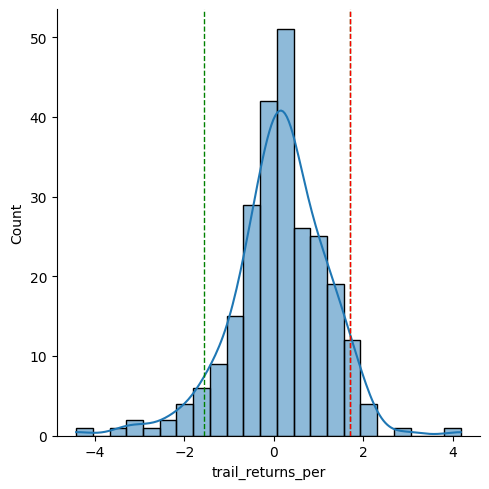

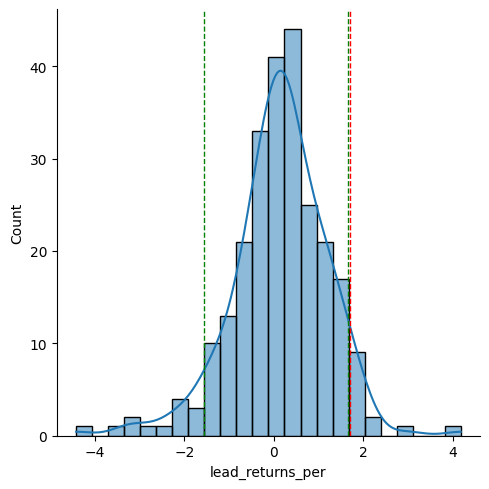

In [15]:
# distribution of returns for any normal day -> want returns to be past the 0.95 line we plot
upper_threshold = np.quantile(vox_tp_idx_state['trail_returns_per'].iloc[1:], .95)
lower_threshold = np.quantile(vox_tp_idx_state['trail_returns_per'].iloc[1:], .05)
sns.displot(vox_tp_idx_state['trail_returns_per'].iloc[1:], kde=True)
plt.axvline(x=upper_threshold, linewidth=1, color='green', ls='--')
plt.axvline(x=lower_threshold, linewidth=1, color='green', ls='--')
plt.axvline(x=tper.mean(), linewidth=1, color='red', ls='--')
plt.show()

upper_threshold = np.quantile(vox_tp_idx_state['lead_returns_per'].iloc[1:], .95)
lower_threshold = np.quantile(vox_tp_idx_state['lead_returns_per'].iloc[1:], .05)
sns.displot(vox_tp_idx_state['lead_returns_per'].iloc[1:], kde=True)
plt.axvline(x=upper_threshold, linewidth=1, color='green', ls='--')
plt.axvline(x=lower_threshold, linewidth=1, color='green', ls='--')
plt.axvline(x=tper.mean(), linewidth=1, color='red', ls='--')
plt.show()

In [16]:
print(np.var(b_trail))
print(np.var(b_lead))
print(np.var(tper))

1.1297117934070169
1.1233786076027348
9.845513333599543


In [24]:
# need to drop target state rows for independent t-test
bdf = vox_tp_idx_state.drop(vox_tp_idx_state[vox_tp_idx_state[state] == value].index) # drop all rows that ARE the target state
b_trail = bdf['trail_returns_per'].iloc[1:] # daily returns for everyday, regardless of state (benchmark)
b_lead = bdf['lead_returns_per'].iloc[1:len(bdf)-1] # daily returns for everyday, regardless of state (benchmark)

In [27]:
b_lead

1      1.138482
2      0.433656
3      0.744152
4     -1.167250
6      1.579884
         ...   
245    0.671097
246    0.331237
247    0.061900
248   -0.199336
250    0.936704
Name: lead_returns_per, Length: 187, dtype: float64

In [28]:
# y = tsla_price_data.loc[tsla_price_data['Streak'] == label, 'Next Chg_Pct']

# https://pingouin-stats.org/build/html/generated/pingouin.ttest.html
trail_results = pg.ttest(tper, b_trail, paired=False, alternative = 'greater', correction=True)
lead_results = pg.ttest(tper, b_lead, paired=False, alternative = 'greater', correction=True)
print(trail_results)
print(lead_results)

# for label in labels:
#     y = tsla_price_data.loc[tsla_price_data['Streak'] == label, 'Next Chg_Pct']
#     results = pg.ttest(x, y, alternative = 'greater')
#     p_val_dict[label] = results.loc[results.index[0], 'p-val']

               T        dof alternative     p-val        CI95%   cohen-d  \
T-test  2.978939  62.329575     greater  0.002059  [0.54, inf]  0.704387   

          BF10     power  
T-test  19.161  0.999008  
               T        dof alternative     p-val        CI95%   cohen-d  \
T-test  3.718186  63.071251     greater  0.000214  [0.85, inf]  0.860838   

           BF10     power  
T-test  180.047  0.999983  


In [31]:
from scipy import stats

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
print(stats.ttest_ind(tper, b_trail, equal_var=False, alternative="greater"))
print(stats.ttest_ind(tper, b_lead, equal_var=False, alternative="greater"))

Ttest_indResult(statistic=2.97893852335186, pvalue=0.0020590179648614384)
Ttest_indResult(statistic=3.7181860296625153, pvalue=0.00021431294223646477)


In [13]:
max_upstate = max(vox_tp_idx_state['upstate'])
max_upstate

12

In [17]:
# globals
TIME_PERIOD = "5y" # yahoo finance format
FILENAME = "5y-Analysis"
COMPARE_COL = "Close"
LOR = 1
state_processor_tp = StateProcessor("asset_tp", "ticker", TIME_PERIOD, filename=FILENAME)
state_processor_tp.write_csv_header(filename=FILENAME)
ticker = 'VOX'
print(f'analyzing {ticker} ...')
asset = yf.Ticker(ticker)
asset_tp = asset.history(period=TIME_PERIOD)
# new object of the state processor for a specific ticker
state_processor_tp = StateProcessor(asset_tp, ticker, TIME_PERIOD, filename=FILENAME)

state = "upstate"
print('upstate analysis ...')
# upstate means nothing when it is 0 (it is an downstate)
for value in range(1, state_processor_tp.max_upstate):
    print(f'calculating upstate analysis for value {value} ...')
    state_processor_tp.calculate_test_benchmarks(state, value)

analyzing VOX ...
upstate analysis ...


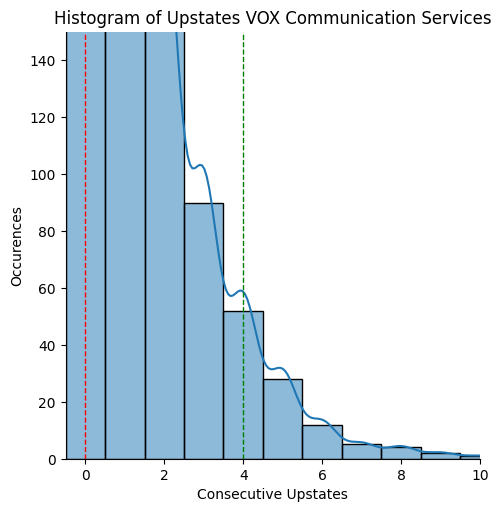

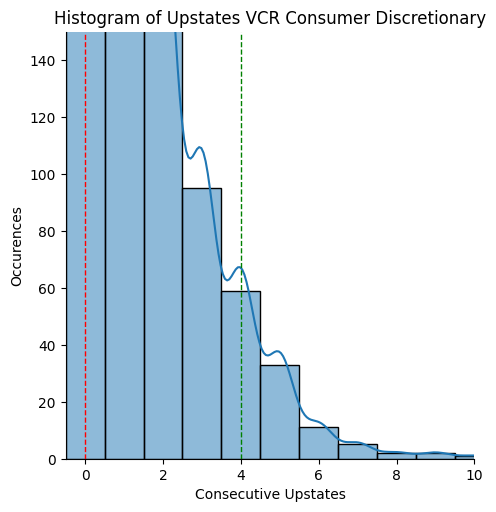

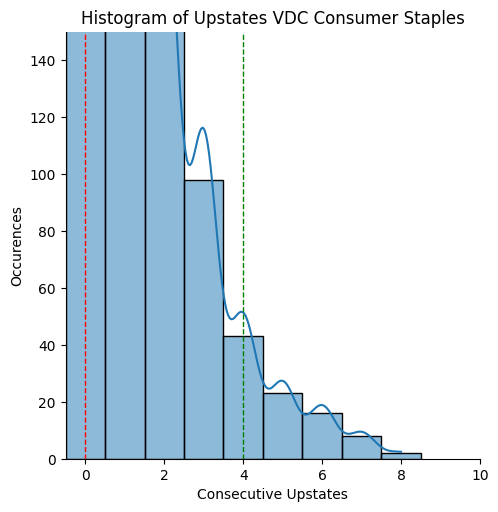

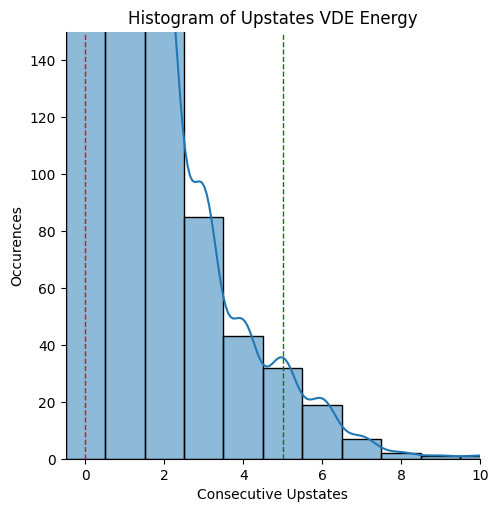

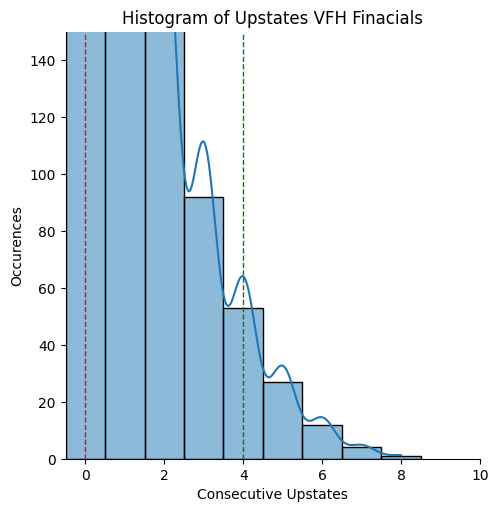

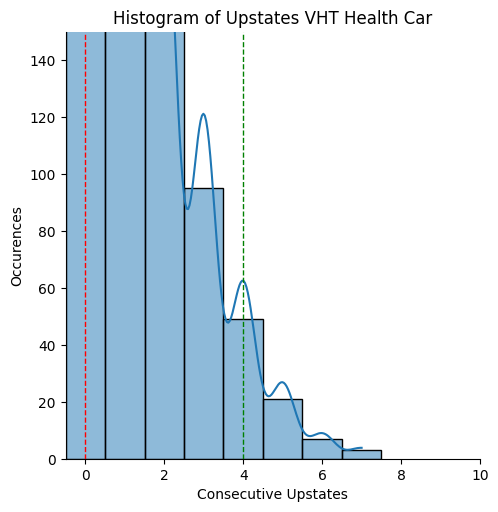

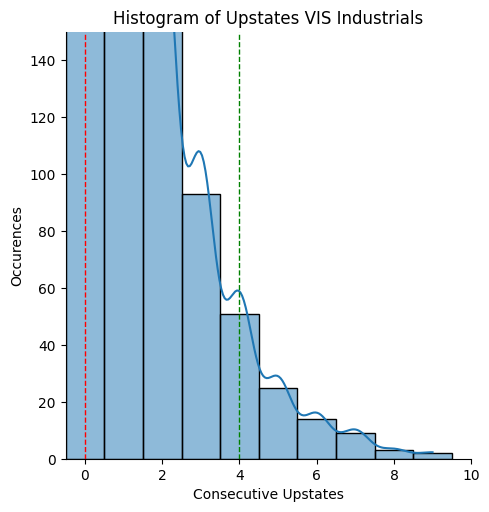

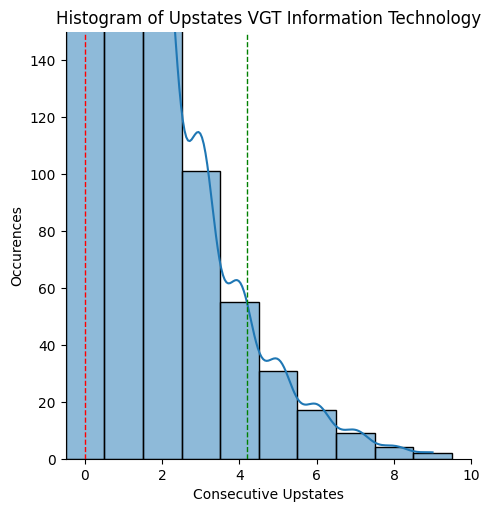

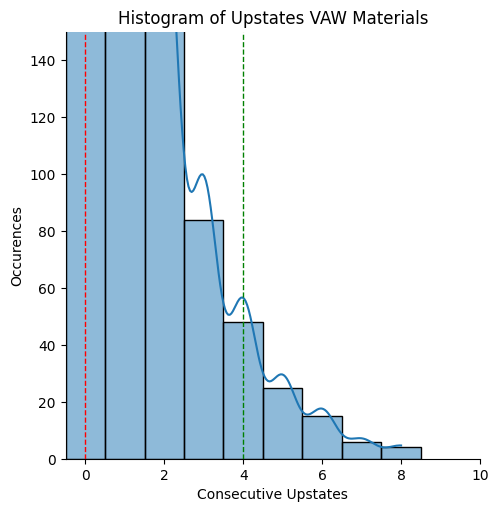

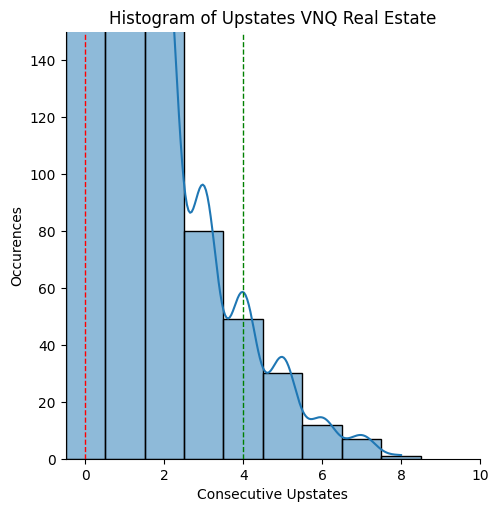

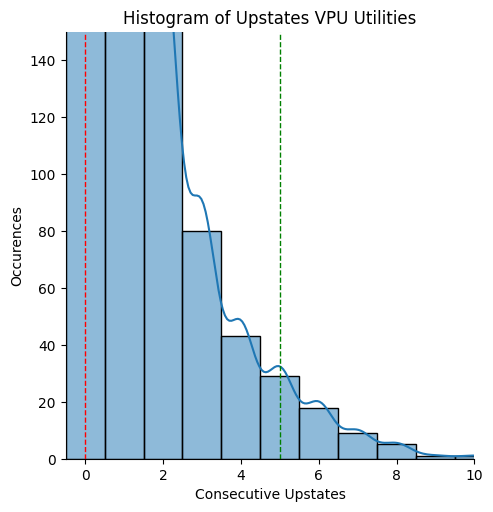

In [11]:
# plot upstates
for i in range(len(DATASETS)):
    etf_name = DATASETS[i]
    histogram_title = "Histogram of Upstates {}".format(etf_name)
    # plot_histogram(sector_etf_idx_state[i], 'upstate', histogram_title, "Consecutive Upstates", 0, 10, "Occurences", 0, 150)
    plot_histogram(sector_etf_idx_state[i], 'upstate', histogram_title, "Consecutive Upstates", -0.5, 10, "Occurences", 0, 150)

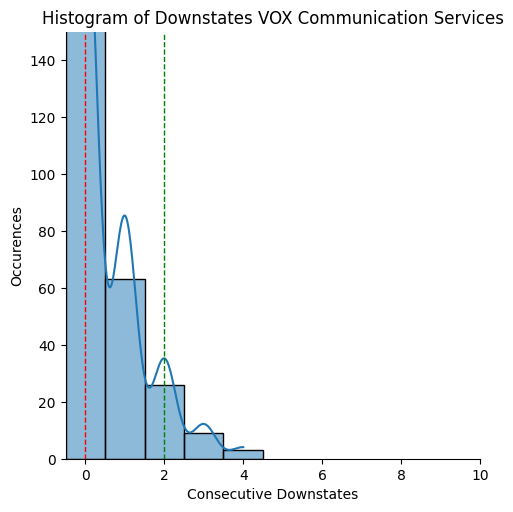

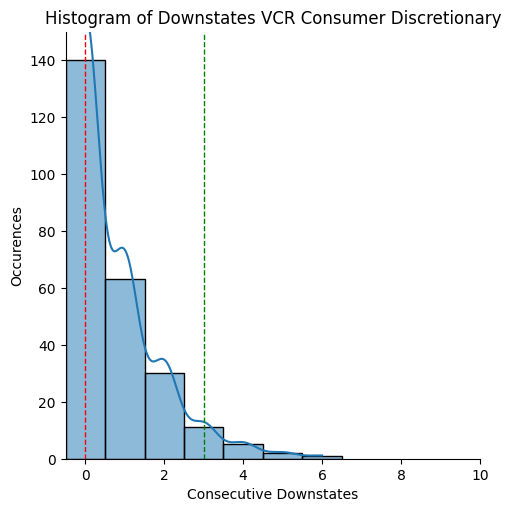

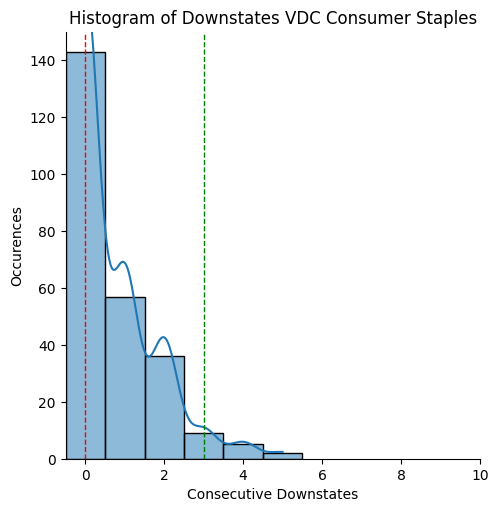

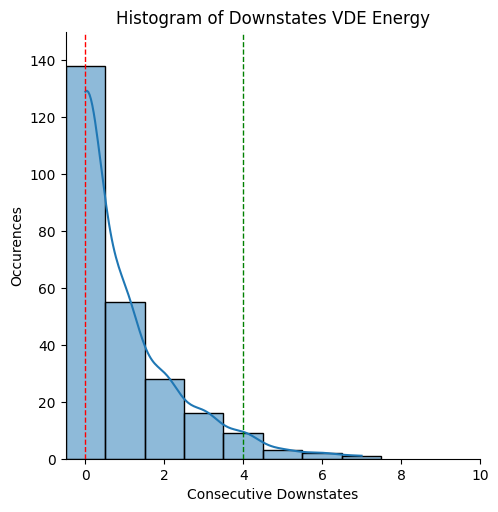

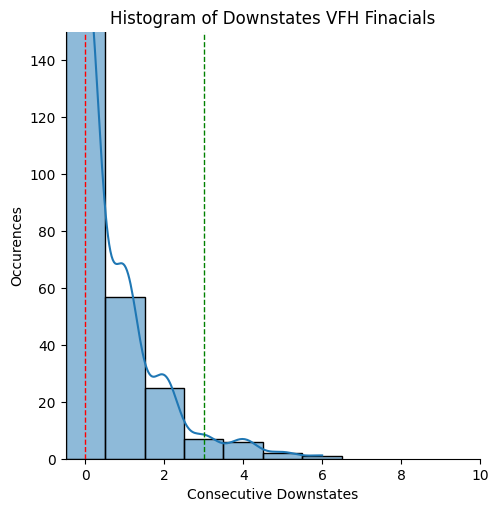

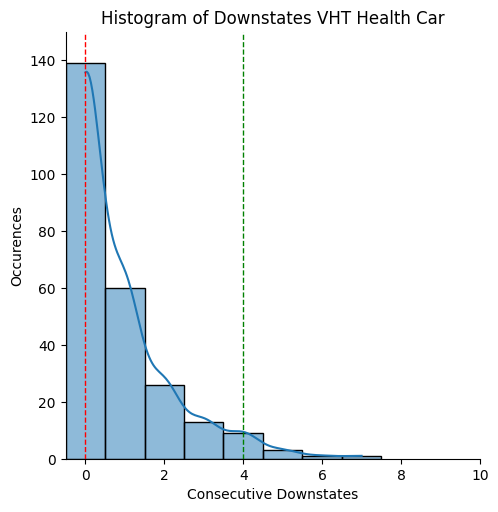

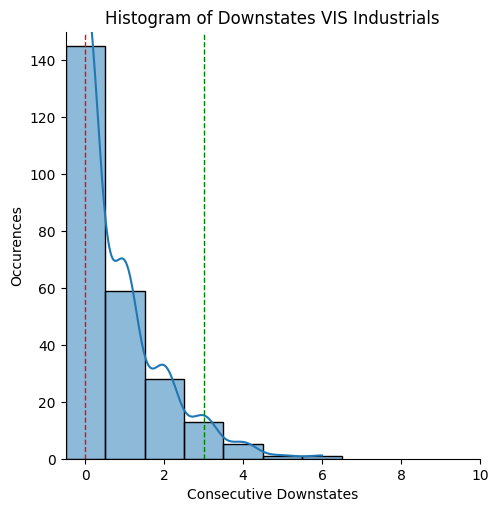

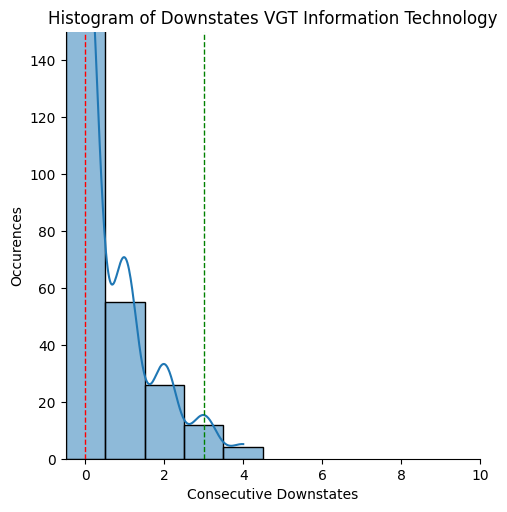

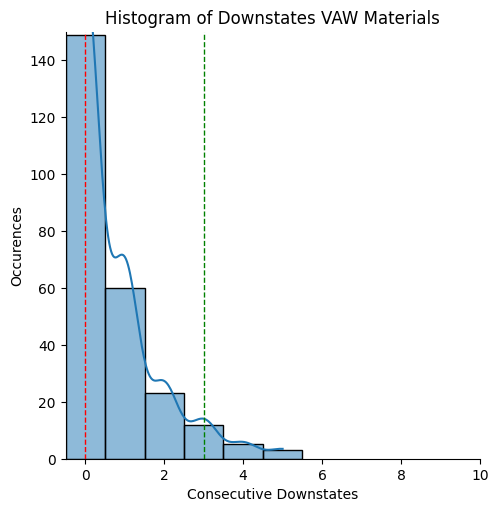

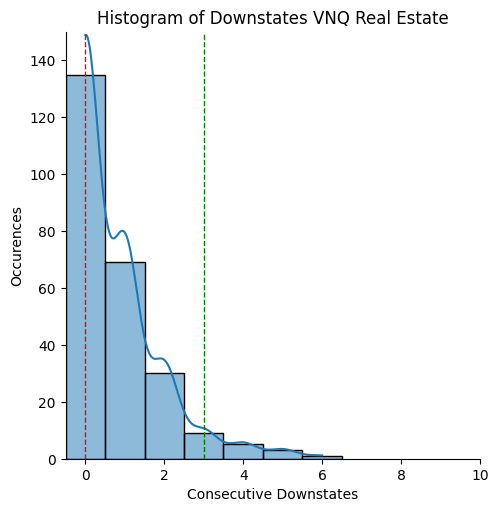

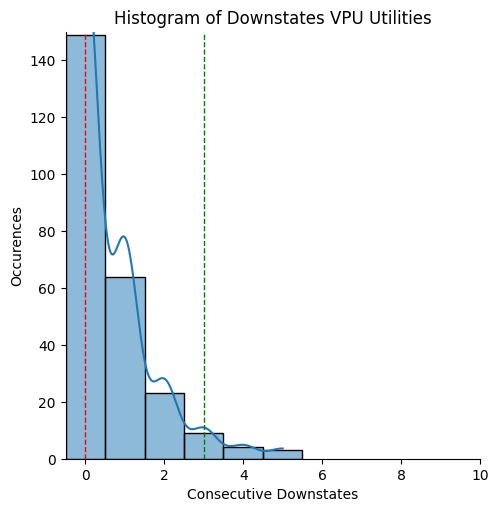

In [25]:
# plot downstates
for i in range(len(DATASETS)):
    etf_name = DATASETS[i]
    histogram_title = "Histogram of Downstates {}".format(etf_name)
    plot_histogram(sector_etf_idx_state[i], 'downstate', histogram_title, "Consecutive Downstates", -0.5, 10, "Occurences", 0, 150)

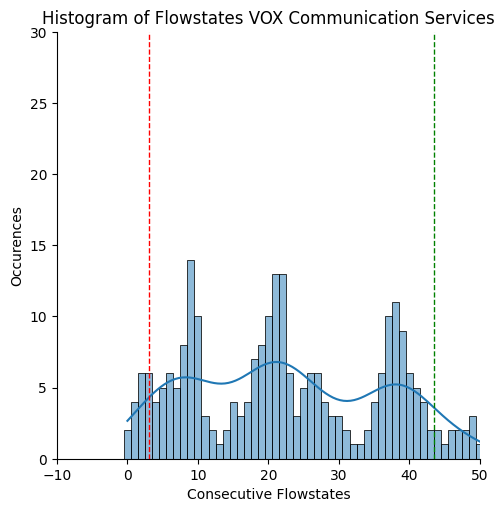

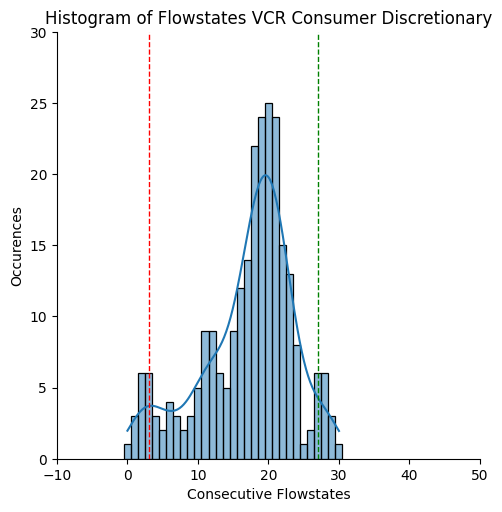

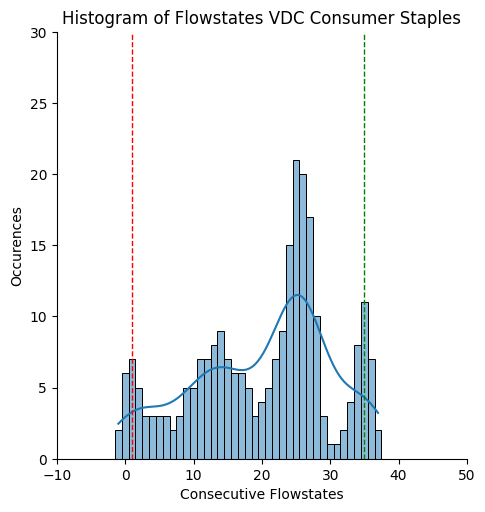

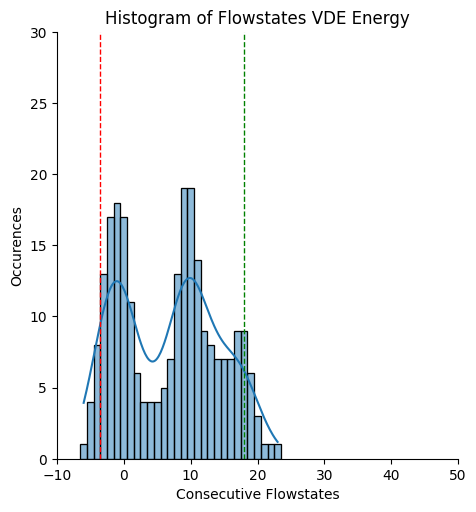

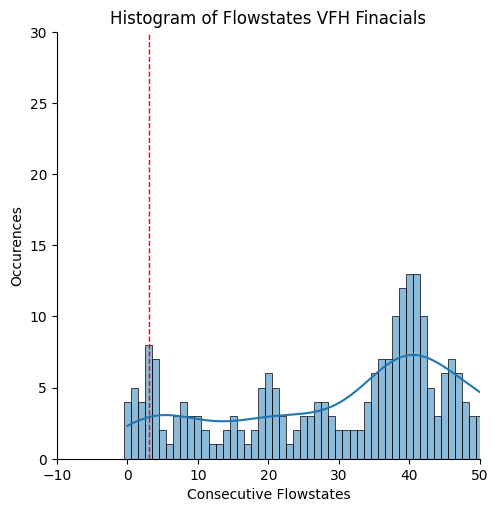

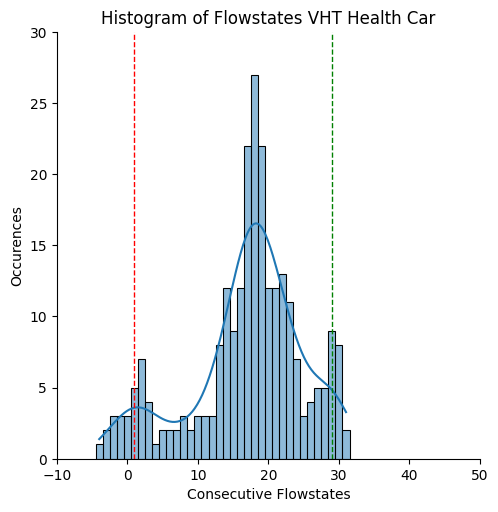

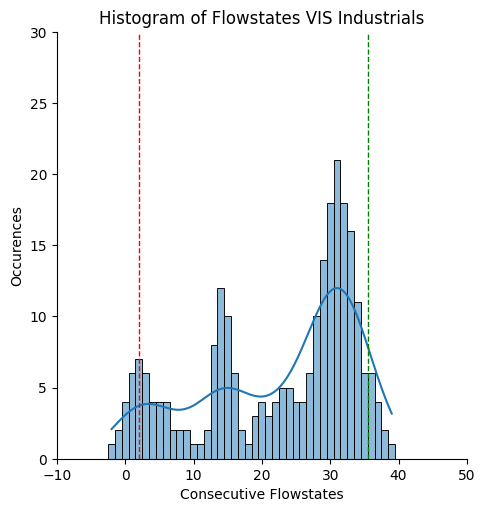

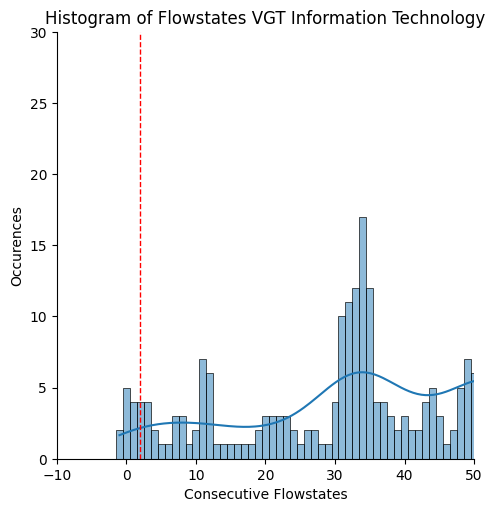

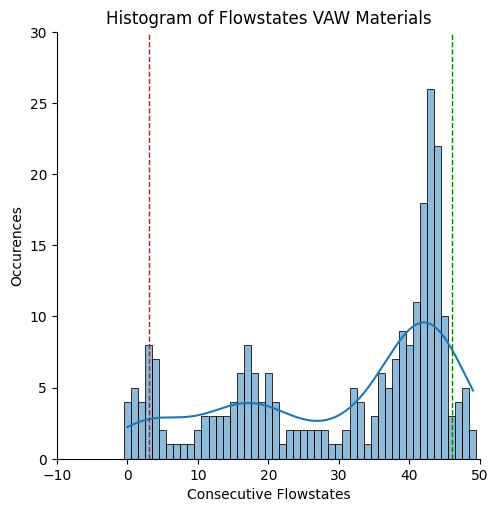

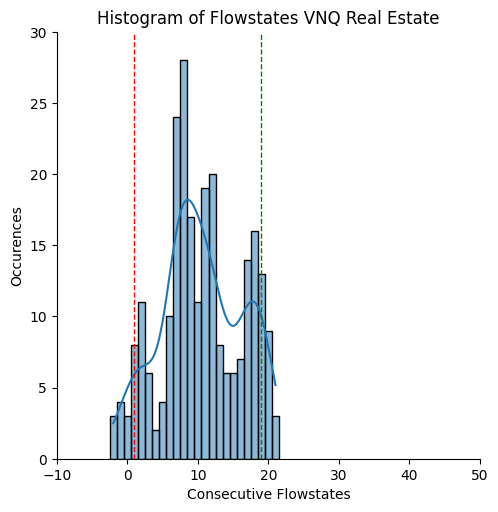

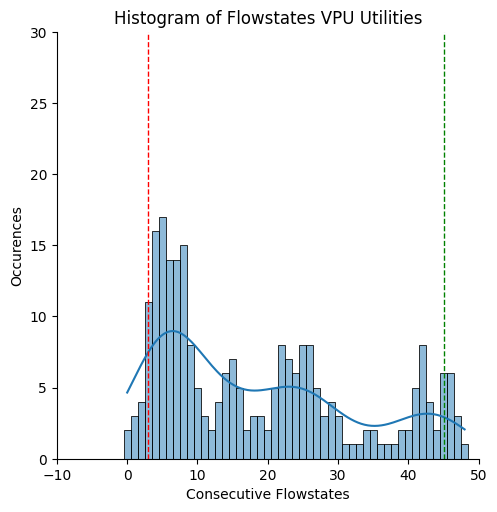

In [26]:
# plot flowstates
for i in range(len(DATASETS)):
    etf_name = DATASETS[i]
    histogram_title = "Histogram of Flowstates {}".format(etf_name)
    plot_histogram(sector_etf_idx_state[i], 'flowstate', histogram_title, "Consecutive Flowstates", -10, 50, "Occurences", 0, 30)

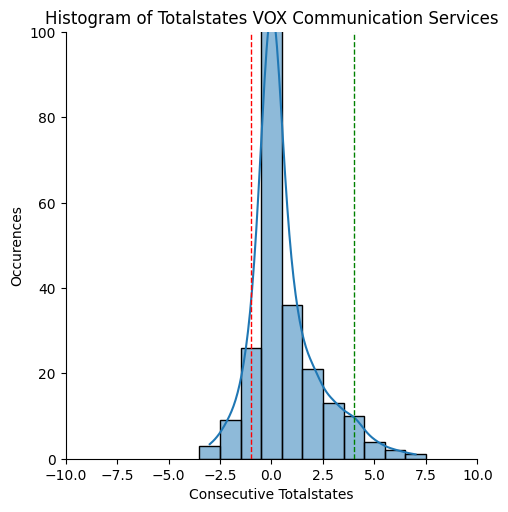

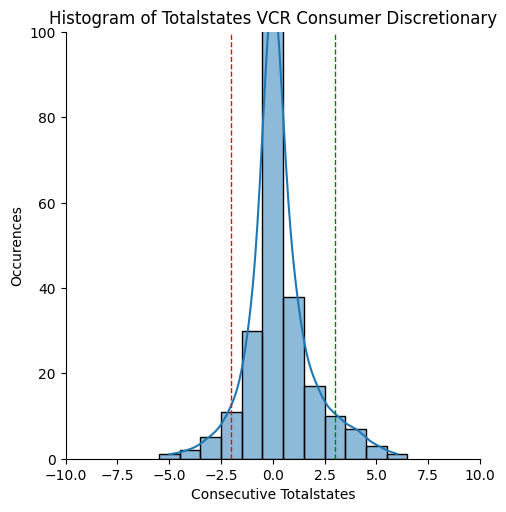

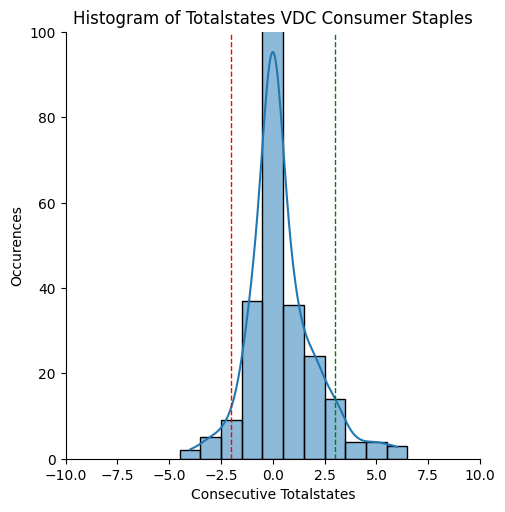

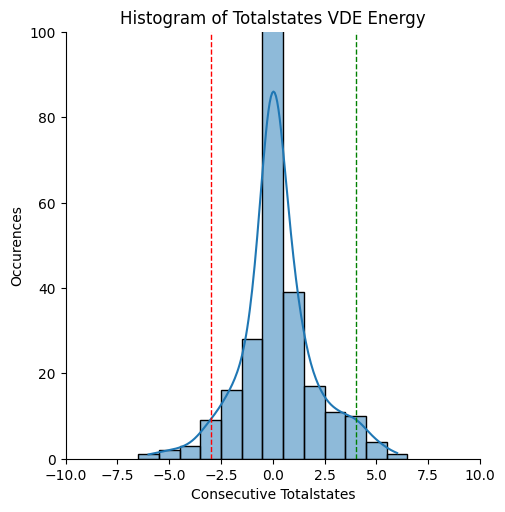

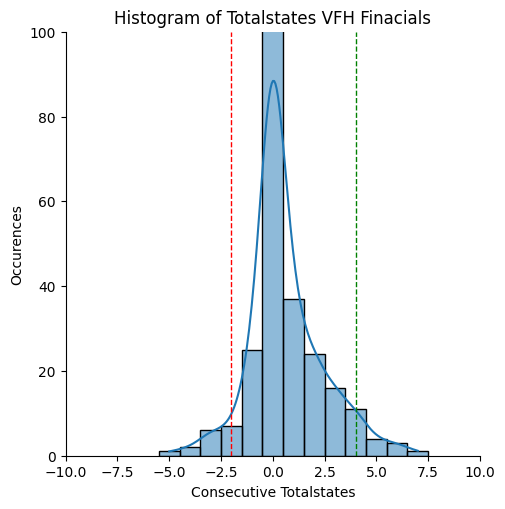

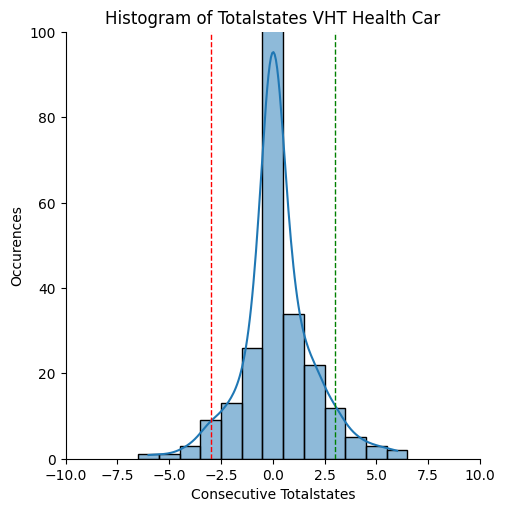

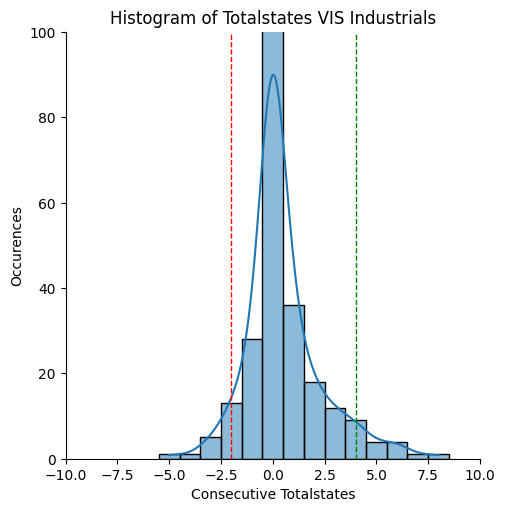

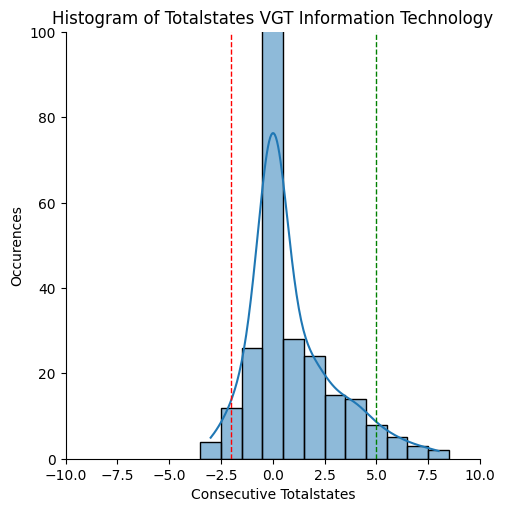

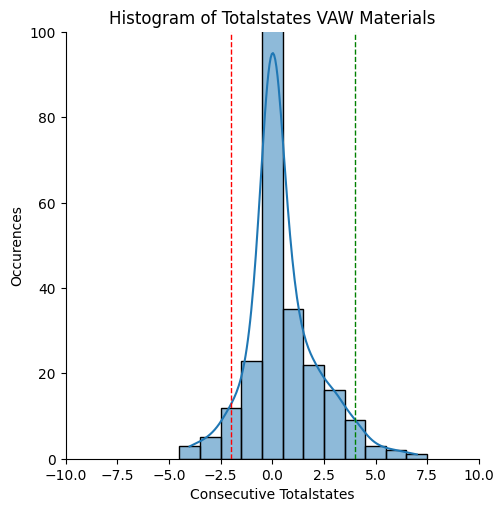

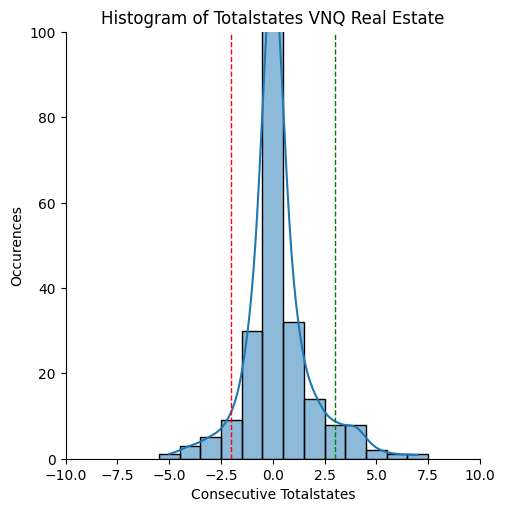

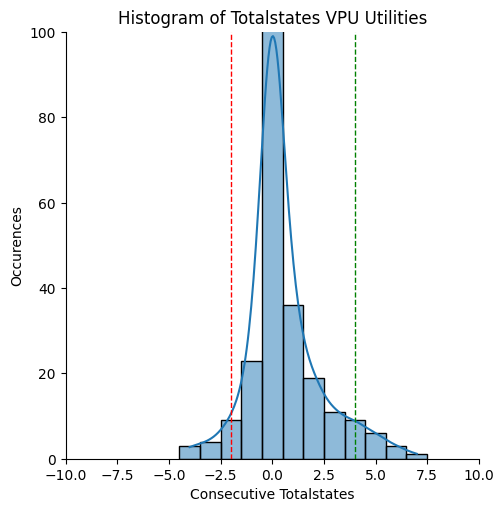

In [27]:
# plot totalstates
for i in range(len(DATASETS)):
    etf_name = DATASETS[i]
    histogram_title = "Histogram of Totalstates {}".format(etf_name)
    plot_histogram(sector_etf_idx_state[i], 'totalstate', histogram_title, "Consecutive Totalstates", -10, 10, "Occurences", 0, 100)
